Dataset 1


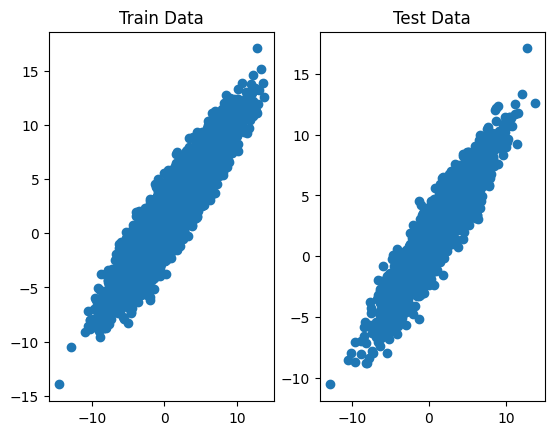

Dataset 2


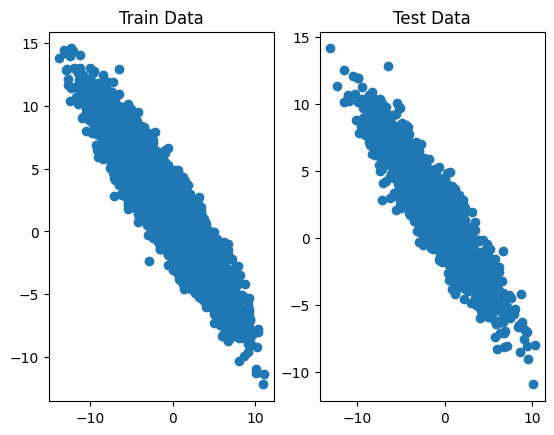

In [2]:
import sys
sys.path.append('/home/dominhnhat/Classroom/deepul')
from deepul.hw2_helper import *
visualize_q1_data('a', 1)
visualize_q1_data('a', 2)

Final -ELBO: 4.4537, Recon Loss: 2.8499, KL Loss: 1.6038


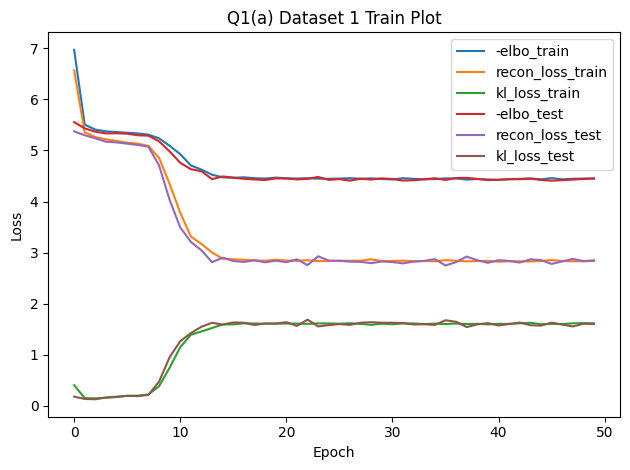

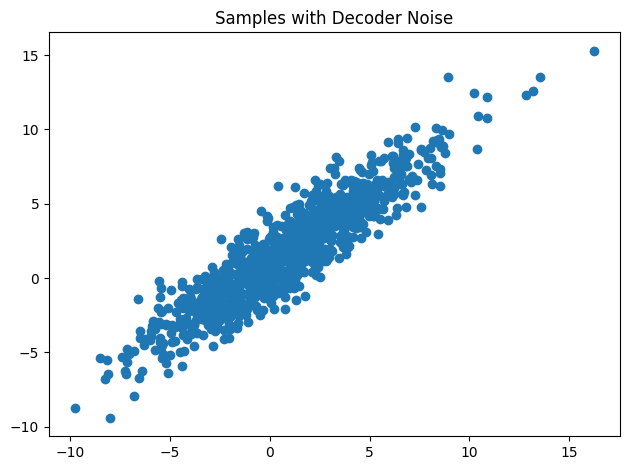

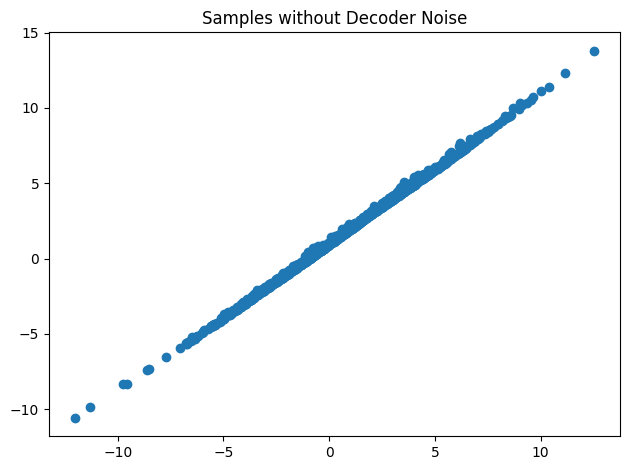

In [4]:
from collections import OrderedDict
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim

class MLP(nn.Module):
    def __init__(self, input_shape, output_shape, hiddens = []):
        super(MLP, self).__init__()
        if isinstance(input_shape, int):
            input_shape = (input_shape,)
        if isinstance(output_shape, int):
            output_shape = (output_shape,)

        self.input_shape = input_shape
        self.output_shape = output_shape
        self.hiddens = hiddens

        #make a basic MLP for encoder and decoder
        layers = []
        prev_h = np.prod(input_shape)
        for h in hiddens + [np.prod(output_shape)]:
            layers.append(nn.Linear(prev_h, h))
            layers.append(nn.ReLU())
            prev_h = h
        #drop the last RElU layer as we will try to output mean and variance
        layers.pop()

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        tmp = x.shape[0]
        x = x.view(tmp, -1)
        return self.net(x).view(tmp, *self.output_shape)

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, enc_hiddens = [], dec_hiddens = []):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.encoder = MLP(input_dim, 2*latent_dim, enc_hiddens)
        self.decoder = MLP(latent_dim, 2*input_dim, dec_hiddens)

    def loss(self, x):
        #here we split the output in half by column, the first half is mean, the second is variance
        mu_z, log_std_z = self.encoder(x).chunk(2, dim=1)

        #remember the log_std_z.exp() to avoid negative variance
        z = torch.randn_like(mu_z) * log_std_z.exp() + mu_z
        mu_x, log_std_x = self.decoder(z).chunk(2, dim=1)

        #calculate reconstruction loss, based on our observed normal distribution
        recon_loss = 0.5 * np.log(2 * np.pi) + log_std_x + \
                     (x - mu_x) ** 2 * torch.exp(-2 * log_std_x) * 0.5
        recon_loss = recon_loss.sum(1).mean()

        #KL divergence
        kl_loss = -log_std_z - 0.5 + (torch.exp(2 * log_std_z) + mu_z ** 2) * 0.5
        kl_loss = kl_loss.sum(1).mean()

        return OrderedDict(loss=recon_loss + kl_loss, recon_loss=recon_loss,
                           kl_loss=kl_loss)

    def sample(self, n, noise = True):
        with torch.no_grad():
            z = torch.randn(n, self.latent_dim).cuda()
            mu_x, log_std_x = self.decoder(z).chunk(2, dim=1)
            if noise:
                x = torch.randn_like(mu_x) * log_std_x.exp() + mu_x
            else:
                x = mu_x
        return x.cpu().numpy()

def train_1_epoch(model, optimizer, train_loader):
    elbo_loss, recon_loss, kl_loss = [], [], []
    model.train()
    for x in train_loader:
        x = x.cuda()
        out = model.loss(x)
        optimizer.zero_grad()
        out['loss'].backward()
        optimizer.step()

        elbo_loss.append(out['loss'].item())
        recon_loss.append(out['recon_loss'].item())
        kl_loss.append(out['kl_loss'].item())

    return np.mean(elbo_loss), np.mean(recon_loss), np.mean(kl_loss)

def evaluate_test_loss(model, test_loader):
    model.eval()
    elbo_loss, recon_loss, kl_loss = [], [], []
    for x in test_loader:
        x = x.cuda()
        out = model.loss(x)

        elbo_loss.append(out['loss'].item())
        recon_loss.append(out['recon_loss'].item())
        kl_loss.append(out['kl_loss'].item())
    return np.mean(elbo_loss), np.mean(recon_loss), np.mean(kl_loss)

def train(model, optimizer, train_data, test_data, epochs):
    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)
    train_losses, test_losses = [], []
    for epoch in range(epochs):
        train_loss = train_1_epoch(model, optimizer, train_loader)
        test_loss = evaluate_test_loss(model, test_loader)
        train_losses.append(np.array(train_loss))
        test_losses.append(np.array(test_loss))

    return np.array(train_losses), np.array(test_losses)

def q1(train_data, test_data, part, dset_id):
    """
    train_data: An (n_train, 2) numpy array of floats
    test_data: An (n_test, 2) numpy array of floats

    (You probably won't need to use the two inputs below, but they are there
     if you want to use them)
    part: An identifying string ('a' or 'b') of which part is being run. Most likely
          used to set different hyperparameters for different datasets
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a numpy array of size (1000, 2) of 1000 samples WITH decoder noise, i.e. sample z ~ p(z), x ~ p(x|z)
    - a numpy array of size (1000, 2) of 1000 samples WITHOUT decoder noise, i.e. sample z ~ p(z), x = mu(z)
    """

    """ YOUR CODE HERE """
    model = VAE(2, 2, [128, 128], [128, 128]).cuda()
    optimizer = optim.Adam(model.parameters(), lr=3e-4)
    epochs = 50
    train_loss, test_loss = train(model, optimizer, train_data, test_data, epochs)
    return train_loss, test_loss, model.sample(1000), model.sample(1000, noise=False)

q1_save_results('a', 1, q1)
